In [ ]:
from diffusers import AutoPipelineForText2Image
import torch
import numpy as np
import os
import torch.nn.functional as F
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe = pipe.to("cuda")

In [2]:
import sys
from ovam_turbo.stable_diffusion import StableDiffusionHooker
from ovam_turbo.utils import set_seed
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [3]:
def normalize_channels(down,mid,up):

    down0,down1,down2 = down[0][0], down[0][1], down[0][2]
    up0,up1,up2 = up[0][0] ,up[0][1] ,up[0][2]
    mid0 = mid[0][0]
    layer_list = [down0,down1,down2,mid0,up0,up1,up2]

    new_layer_list = []
    for att in layer_list:
        att = F.interpolate(
                            torch.tensor(att)[None,...].float(),
                            size=(128,128),
                            mode="bilinear",
                        )[0]
        shape = att.shape
        att = att.reshape(shape[0],-1)
        att = (att-att.min(axis=1)[0][..., np.newaxis])
        att = att / att.max(axis=1)[0][..., np.newaxis]
        new_layer_list.append(att)
        
    down = new_layer_list[:3]
    mid = new_layer_list[3]
    up = new_layer_list[4:] 
    return down,mid,up

def find_ranges(ranges, queries):
    results = []
    channel_num = [[] for _ in range(len(ranges))]
    pair_results = []
    
    for n,query in enumerate(queries):
        # If the query is less than the first range start or more than the last
        if query > ranges[-1]:
            results.append(None)  # Query out of range boundaries
            continue

        # Check within the ranges defined
        if query < ranges[0]:
            results.append(0)
            channel_num[0].append(query)
            layer_ = 0
            channel_ = query
            found = True
            pair_results.append((layer_,channel_))
            continue 
        
        found = False
        for i in range(len(ranges) - 1):
            if ranges[i] <= query < ranges[i + 1]:
                results.append(i + 1)  # Append the range number (1-indexed)
                channel_num[i+1].append(query-ranges[i])
                layer_ = i+1
                channel_ = query - ranges[i]
                found = True
                break
        
        # If the query is within the last specified range
        if not found and query >= ranges[-1]:
            results.append(len(ranges))
            channel_num[len(ranges)].append(query-ranges[-1])
            layer_ = len(ranges)
            channel_ = query - ranges[-1]
        pair_results.append((layer_,channel_))    
    
    return results,channel_num, pair_results

In [4]:
common_samples = []
rare_samples = []
for i in range(1):
    set_seed(i)
    rare_prompt = f"An apple with creative shape."
    print(rare_prompt)
    _, d_r, m_r, u_r = pipe(rare_prompt,guidance_scale=0.0, num_inference_steps=1)
    d_r,m_r,u_r = normalize_channels(d_r,m_r,u_r)
    
    com_prompt = "An apple with standard shape."
    print(com_prompt)
    _, d_c, m_c, u_c = pipe(com_prompt,guidance_scale=0.0, num_inference_steps=1)
    d_c,m_c,u_c = normalize_channels(d_c,m_c,u_c)
    down_diff = [torch.sum(torch.abs((d_r[i] - d_c[i])),dim=-1)/16384 for i in range(len(d_r))]
    mid_diff = [torch.sum(torch.abs((m_r[i] - m_c[i])),dim=-1)/16384 for i in range(len(m_r))]
    up_diff = [torch.sum(torch.abs((u_r[i] - u_c[i])),dim=-1)/16384 for i in range(len(u_r))]

An apple with creative shape.


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


An apple with standard shape.


100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


In [5]:
layer_diff = [down_diff[0],down_diff[1],down_diff[2],mid_diff,up_diff[0],up_diff[1],up_diff[2]]
scores = []
for layer in layer_diff:
    scores.append(layer)
n_mask = int(len(np.hstack(scores))*0.2)
top_channels = np.argsort(np.hstack(scores))[::-1][:n_mask]
score_length = [len(scores[i]) for i in range(len(scores))]
score_length_cum = np.cumsum(score_length)
_,_,top_pairs = find_ranges(score_length_cum,top_channels)

top_dict = {}
# Iterate over the list of tuples
for key, value in top_pairs:
    # Check if the key is already in the dictionary
    if key in top_dict:
        # Append the value to the existing list
        top_dict[key].append(value)
    else:
        # Create a new list for the key
        top_dict[key] = [value]

In [10]:
org_img = []

for i in range(10):
    set_seed(int(i))
    out = pipe("An apple with creative shape.",guidance_scale=0.0, num_inference_steps=1)
    org_img.append(out[0].images[0])

100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


In [19]:
abl_img = []

for i in range(10):
    set_seed(int(i))
    out = pipe("An apple with creative shape.",guidance_scale=0.0, num_inference_steps=1,abl_channels=top_dict)
    abl_img.append(out[0].images[0])

100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


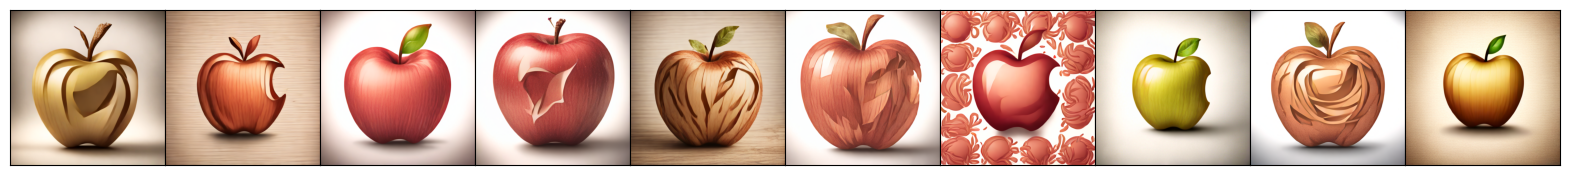

In [12]:
fig = plt.figure(figsize=(20, 4))
gs = gridspec.GridSpec(1,10, hspace=0.0, wspace=0.0)

for i, img in enumerate(org_img):
    ax = plt.subplot(gs[i])    
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

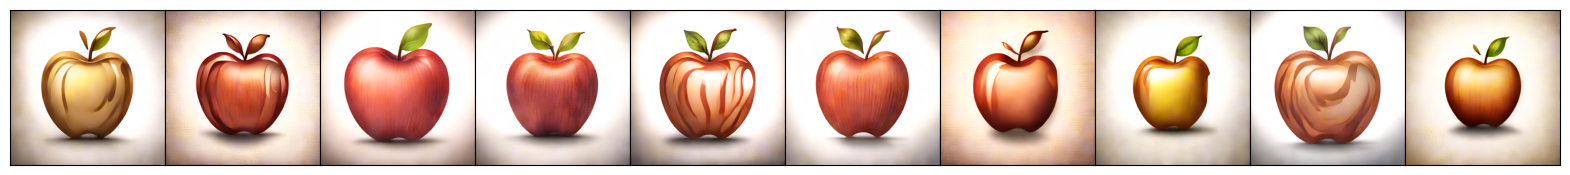

In [20]:
fig = plt.figure(figsize=(20, 4))
gs = gridspec.GridSpec(1,10, hspace=0.0, wspace=0.0)

for i, img in enumerate(abl_img):
    ax = plt.subplot(gs[i])    
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])